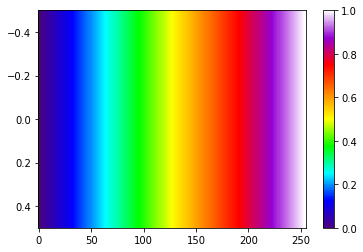

In [1]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import pyvista as pv

# Définir les couleurs du bas au haut de la colormap de l'image
colors = [
    (75/255, 0, 130/255),   # indigo
    (0, 0, 255/255),        # bleu
    (0, 255/255, 255/255),  # cyan
    (0, 255/255, 0),        # vert
    (255/255, 255/255, 0),  # jaune
    (255/255, 127/255, 0),  # orange
    (255/255, 0 , 0),        # rouge
    (148/255, 0, 211/255),  # violet
    (1, 1, 1)               # blanc

]

cmap_name = 'custom_gradient'

# Créer la colormap
custom_cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=256)


# Afficher la colormap dans Matplotlib
plt.imshow(np.linspace(0, 1, 256)[None, :], aspect='auto', cmap=custom_cmap)
plt.colorbar()
plt.show()


In [2]:
import os
import feelpp
from feelpp.toolboxes.cfpdes import *
from tools.lap2D_pinns import Run_laplacian2D, Poisson_2D, PoissonDisk2D
from scimba.equations import domain

import pandas as pd
import numpy as np

import plotly.express as px
from plotly.subplots import make_subplots
import itertools

class Poisson:
  """
  Solves the problem
  -Laplacian u = f   in Omega
  u            = g   in boundary
  
  - with f,g are set by the user
  """
  def __init__(self, dim=2, order=1):

    self.dim   = dim
    self.model = dict()
    self.order = order
  
  def genCube(self, filename, h=0.1):
    """
    Generate a cube geometry following the dimension  self.dim
    """

    
    geo="""SetFactory("OpenCASCADE");
    h={};
    dim={};
    """.format(h, self.dim)
    
    if self.dim==2 :
        geo+="""
        Rectangle(1) = {0, 0, 0, 1, 1, 0};
        Characteristic Length{ PointsOf{ Surface{1}; } } = h;
        Physical Curve("Gamma_D") = {1,2,3,4};
        Physical Surface("Omega") = {1};
        """
    elif self.dim==3 :
        geo+="""
        Box(1) = {0, 0, 0, 1, 1, 1};
        Characteristic Length{ PointsOf{ Volume{1}; } } = h;
        Physical Surface("Gamma_D") = {1,2,3,4,5,6};
        Physical Volume("Omega") = {1};
        """
    with open(filename, 'w') as f:
        f.write(geo)

  
  
  def __call__(self,
               h=0.1,                                       # mesh size 
               order=1,                                 # polynomial order 
               name='u',                                # name of the variable u
               rhs='8*pi*pi*sin(2*pi*x)*sin(2*pi*y)',   # right hand side
               diff='{1,0,0,1}',                        # diffusion matrix
               g='0',
               geofile=None,
               plot=None,
               solver='feelpp',
               u_exact='sin(2 * pi * x) * sin(2 * pi * y)',
               grad_u_exact = '{2*pi*cos(2*pi*x)*sin(2*pi*y),2*pi*sin(2*pi*x)*cos(2*pi*y)}' 
               ):
    """
    Solves the problem where :
    - h is the mesh size
    - order the polynomial order
    - rhs is the expression of the right-hand side f(x,y)
    """
    self.measures = dict()
    self.u_exact = u_exact
    self.pb    = cfpdes(dim=self.dim, keyword=f"cfpdes-{self.dim}d-p{self.order}")
    self.model = {
      "Name": "Laplacian",
      "ShortName": "Laplacian",
      "Models":
      {
        f"cfpdes-{self.dim}d-p{self.order}":
        {
          "equations":"poisson"
        },
        "poisson":{
          "setup":{
            "unknown":{
              "basis":f"Pch{order}",
              "name":f"{name}",
              "symbol":"u"
            },
            "coefficients":{
              "c": f"{diff}:x:y" if self.dim == 2 else f"{diff}:x:y:z",
              "f": f"{rhs}:x:y"  if self.dim == 2 else f"{rhs}:x:y:z"
            }
          }
        }
      },
      "Materials":
      {
        "Omega":
        {
          "markers":["Omega"]
        }
      },
      "BoundaryConditions":
      {
        "poisson":
        {
          "Dirichlet":
          {
            "g":
            {
              "markers":["Gamma_D"],
              "expr":f"{g}:x:y"
            }
          }
        }
      },
      "PostProcess":
      {
        f"cfpdes-{self.dim}d-p{self.order}":
        {
          "Exports":
          {
            "fields":["all"],
            "expr":{
              #"u": f"{name}:x:y" if self.dim == 2 else f"{name}:x:y:z",         
              "rhs": f"{rhs}:x:y" if self.dim == 2 else f"{rhs}:x:y:z",
              "u_exact" : f"{u_exact}:x:y" if self.dim==2 else f"{u_exact}:x:y:z",
              "grad_u_exact" : f"{grad_u_exact}:x:y" if self.dim==2 else f"{grad_u_exact}:x:y:z",
            }
          },
            "Measures" :
            {
              "Norm" :
              {
                  "poisson" :
                  {
                     "type":["L2-error", "H1-error"],
                     "field":f"poisson.{name}",
                     "solution": f"{u_exact}:x:y" if self.dim==2 else f"{u_exact}:x:y:z",
                     "grad_solution": f"{grad_u_exact}:x:y" if self.dim==2 else f"{grad_u_exact}:x:y:z",
                     "markers":"Omega",
                     "quad":6
                 }
              },
                "Statistics":
                {
                    "mystatA":
                    {
                        "type":["min","max","mean","integrate"],
                        "field":f"poisson.{name}"
                    }
                }
            }
        }
      }
    }

    

    fn = None
    if geofile is None:
      fn = f'omega-{self.dim}.geo'
      self.genCube(fn, h)
    else:
      fn = geofile
    
        
##________________________

  # Solving

    if solver == 'feelpp':
      def feel_solver(h, dim=2,verbose=False):
        if verbose:
          print(f"Solving the laplacian problem for hsize = {h}...")
        feelpp_mesh = feelpp.load(feelpp.mesh(dim=self.dim, realdim=self.dim), fn, h)
        self.pb.setMesh(feelpp_mesh)
        self.pb.setModelProperties(self.model)
        self.pb.init(buildModelAlgebraicFactory=True)
        self.pb.printAndSaveInfo()
        self.pb.solve()
        self.pb.exportResults()
        measures = self.pb.postProcessMeasures().values()

        return measures
      
      self.measures = feel_solver(h=h, dim=self.dim,verbose=True)

      
      """
      try:
        import pandas as pd
        df=pd.DataFrame([measures])
        print(df)
      except ImportError:
        print("cannot import pandas, no problem it was just a test")
    """
##______________________
      #mesh = self.pb.mesh()
      #function_space = self.pb.functionSpace()
      #dofs = function_space.dofs()
##________________________
      #return mesh, dofs
##________________________

    elif solver == 'scimba':
      print("Solving using Scimba")
      diff = diff.replace('{', '(').replace('}', ')')
      print(diff)
      # Define a disk domain
      if geofile == 'geo/disk.geo' :
        xdomain = domain.SpaceDomain(2, domain.DiskBasedDomain(2, center=[0.0, 0.0], radius=1.0))
        pde_disk = PoissonDisk2D(xdomain,  rhs= rhs, diff= diff, g= g, u_exact=self.u_exact)
        Run_laplacian2D(pde_disk)

      # Define a square domain
      elif geofile == None:
        xdomain = domain.SpaceDomain(2, domain.SquareDomain(2, [[0.0, 1.0], [0.0, 1.0]]))
        pde = Poisson_2D(xdomain, rhs= rhs, diff= diff, g= g, u_exact=self.u_exact)
        Run_laplacian2D(pde)
##________________________

     
    # Plots
    if plot != None:
      
      from xvfbwrapper import Xvfb
      import pyvista as pv 
      import matplotlib.pyplot as plt


      vdisplay = Xvfb()
      vdisplay.start()
      pv.set_jupyter_backend('static') 
      #pv.start_xvfb()
      def pv_get_mesh(mesh_path):
          reader = pv.get_reader(mesh_path)
          mesh = reader.read()
          return mesh

      def pv_plot(mesh, field, clim=None, cmap=custom_cmap, cpos='xy', show_scalar_bar=True, show_edges=True):
          mesh.plot(scalars=field, clim=clim, cmap=cmap, cpos=cpos, show_scalar_bar=show_scalar_bar, show_edges=show_edges)

      def myplots(dim=2, field=f"cfpdes.poisson.{name}", factor=1, cmap=custom_cmap):
          mesh = pv_get_mesh((f"cfpdes-{self.dim}d-p{self.order}.exports/Export.case"))
          #pv_plot(mesh, field)
          pl = pv.Plotter(shape=(1,2))
          
          
          pl.add_title(f'Solution P{order}', font_size=18)
          pl.add_mesh(mesh[0], scalars = f"cfpdes.poisson.{name}", cmap=custom_cmap)
          pl.subplot(0,1)
          pl.add_title('u_exact=' + u_exact, font_size=10)
          pl.add_mesh(mesh[0].copy(), scalars = 'cfpdes.expr.u_exact', cmap=custom_cmap)
          pl.link_views()
          pl.show()
          pl.screenshot(plot)
          """
          pl = pv.Plotter()
          #contours = mesh[0].contour()
          #pl.add_mesh(mesh[0], opacity=0.85, cmap=custom_cmap)
          #pl.add_mesh(contours, color="white", line_width=3, render_lines_as_tubes=True)
          pl.show()
          if dim == 2:
              warped = mesh[0].warp_by_scalar(field, factor=factor)
              warped.plot(cmap=custom_cmap, show_scalar_bar=False, show_edges=True)
          else:
              slices = mesh.slice_orthogonal(x=0.2,y=0.4,z=.6)
              slices.plot()
          """
          
            

      myplots(dim=2,factor=0.5)
      



      """
      mesh = pv.get_reader(f"cfpdes-{self.dim}d-p{self.order}.exports/Export.case").read()
      
      pl = pv.Plotter(shape=(1,2))
      pl.add_title(f'Solution P{order}', font_size=18)
      pl.add_mesh(mesh[0], scalars = f"cfpdes.poisson.{name}", cmap=custom_cmap)
      pl.subplot(0,1)
      pl.add_title('u=' + u_exact, font_size=10)
      pl.add_mesh(mesh[0].copy(), scalars = 'cfpdes.expr.u_exact', cmap=custom_cmap)
      pl.link_views()

      if self.dim ==3:
        pl.view_isometric()
      else:
        pl.view_xy()  # if mesh_2D is on the xy plane.        
      
      pl.show()
      pl.screenshot(plot)
      """
    
##________________________

  # Convergence
  
  def runLaplacianPk(self, df,model, verbose=False):
      """generate the Pk case

      Args:
          order (int, optional): order of the basis. Defaults to 1.
      """
      meas=dict()
      dim,order,json=model
      for h in df['h']:
          m= self.measures
          for norm in ['L2','H1']:
              meas.setdefault(f'P{order}-Norm_poisson_{norm}-error', [])
              meas[f'P{order}-Norm_poisson_{norm}-error'].append(m.pop(f'Norm_poisson_{norm}-error'))
      df=df.assign(**meas)
      for norm in ['L2','H1']:
          df[f'P{order}-poisson_{norm}-convergence-rate']=np.log2(df[f'P{order}-Norm_poisson_{norm}-error'].shift() / df[f'P{order}-Norm_poisson_{norm}-error']) / np.log2(df['h'].shift() / df['h'])
      return df

  def runConvergenceAnalysis(self, json,dim=2,hs=[0.1,0.05,0.025,0.0125],orders=[1,2],verbose=False):
      df=pd.DataFrame({'h':hs})
      for order in orders:
          df=self.runLaplacianPk( df=df,model=[dim,order,json(dim=dim,order=order)],verbose=verbose)
      print(df.to_markdown())
      return df
  #laplacian_json = lambda order,dim=2,name="u": self.model
  #df= runConvergenceAnalysis(self, json=laplacian_json,dim=2,verbose=True)

  

  def plot_convergence(self, df,dim,orders=[1,2]):
      fig=px.line(df, x="h", y=[f'P{order}-Norm_poisson_{norm}-error' for order,norm in list(itertools.product(orders,['L2','H1']))])
      fig.update_xaxes(title_text="h",type="log")
      fig.update_yaxes(title_text="Error",type="log")
      for order,norm in list(itertools.product(orders,['L2','H1'])):
          fig.update_traces(name=f'P{order} - {norm} error - {df[f"P{order}-poisson_{norm}-convergence-rate"].iloc[-1]:.2f}', selector=dict(name=f'P{order}-Norm_poisson_{norm}-error'))
      fig.update_layout(
              title=f"Convergence rate for the {dim}D Laplacian problem",
              autosize=False,
              width=900,
              height=900,
          )
      return fig
  #fig= plot_convergence(self, df,dim=2)
  #fig.show()




Using device: cpu
torch loaded; device is cpu


In [3]:
import sys
import feelpp
import feelpp.toolboxes.core as tb

# mandatory things
sys.argv = ["feelpp_app"]
e = feelpp.Environment(sys.argv,
                       opts=tb.toolboxes_options("coefficient-form-pdes", "cfpdes"),
                       config=feelpp.localRepository('feelpp_cfpde'))

# ------------------------------------------------------------------------- #
# Poisson problem
# - div (diff * grad (u)) = f    in Omega
#                     u   = g    in Gamma_D
# Omega = domain, either cube or ball
# Approx = lagrange Pk of order order
# mesh of size h



[ Starting Feel++ ] application feelpp_app version 0.1 date 2024-May-28
 . feelpp_app files are stored in /workspaces/2024-m1-scimba-feelpp/feelppdb/feelpp_cfpde/np_1
 .. logfiles :/workspaces/2024-m1-scimba-feelpp/feelppdb/feelpp_cfpde/np_1/logs


In [4]:
P = Poisson(dim = 2)
P(rhs='-1.0-1*y*x+y*y', g='0', order=1, plot='f4.png')


TypeError: Poisson.__call__.<locals>.feel_solver() missing 1 required positional argument: 'self'

In [ ]:
laplacian_json = lambda order,dim=2,name="u": P.model

with open(f'poisson-{P.dim}d.json', 'w') as f:
      # Write the string to the file
      import json
      f.write(json.dumps(laplacian_json(dim=P.dim,order=1),indent=1))
      # execute the laplacian problem using P1 basis on a mesh of the unit square  of size 0.1
      print('lap  =', P.measures)

df= P.runConvergenceAnalysis( json=laplacian_json,dim=2,verbose=True)


lap  = {'Norm_poisson_H1-error': 4.480046115661911, 'Norm_poisson_L2-error': 0.5021161233875642, 'Statistics_mystatA_integrate': -0.03278631002090035, 'Statistics_mystatA_max': -0.00025644475163748683, 'Statistics_mystatA_mean': -0.03278631002090034, 'Statistics_mystatA_min': -0.07097785994941819}
lap  = {'Norm_poisson_H1-error': 4.480046115661911, 'Norm_poisson_L2-error': 0.5021161233875642, 'Statistics_mystatA_integrate': -0.03278631002090035, 'Statistics_mystatA_max': -0.00025644475163748683, 'Statistics_mystatA_mean': -0.03278631002090034, 'Statistics_mystatA_min': -0.07097785994941819}


KeyError: 'Norm_poisson_L2-error'

In [ ]:

fig= P.plot_convergence(df,dim=2)
fig.show()


In [ ]:

P(rhs='-1.0-1*y*x+y*y', g='0', order=1, solver='scimba')

In [ ]:


# 2D on different domains
P = Poisson(dim = 2)

# for square domain
u_exact = 'sin(2*pi*x) * sin(2*pi*y)'
rhs = '8*pi*pi*sin(2*pi*x) * sin(2*pi*y)'

P(rhs=rhs, g='0', order=1, plot='f2.png', u_exact = u_exact)
P(rhs=rhs, g='0', order=1, solver ='scimba', u_exact = u_exact)

# for disk domain
u_exact =  'sin(pi*(x*x + y*y))'
rhs = '4*pi*sin(pi*(x*x + y*y)) - 4*pi*pi*(x*x + y*y)*cos(pi*(x*x + y*y))'

P(rhs=rhs, g='0', order=1, geofile='geo/disk.geo', plot='2d.png', u_exact = u_exact)
P(rhs=rhs, g='0', order=1, geofile='geo/disk.geo', solver='scimba', u_exact = u_exact)





In [ ]:

"""
u_exact = 'sin(2*pi*x) * sin(2*pi*y)'

P( rhs='-1.0-3*y*x+y*y', g='y', order=1, plot='f3.png', u_exact = u_exact)
P( rhs='-1.0-3*y*x+y*y', g='y', order=1, solver ='scimba')


P( rhs='-1.0-4*y*x+y*y', g='x', order=1, plot='f4.png')
P( rhs='-1.0-4*y*x+y*y', g='x', order=1, solver ='scimba')
"""
P(rhs='1',              g='0', order=1, plot='f5.png')
P(rhs='1 + x-x',              g='0', order=1, solver ='scimba')



In [ ]:

"""
# # 2D with varying anisotropy
#P = Poisson(dim = 2)
P(diff='{1+x,0,0,1+y}', rhs='1', plot='d1.png')
P(diff='(1+x,0,0,1+y)', rhs='1+ x-x', solver='scimba')

P(diff='{x,y,-y,x+y}',  rhs='1', plot='d3.png')
P(diff='(x,y,-y,x+y)',  rhs='1+ x-x', solver='scimba')
"""
